# Linear Regression Primer
Learn how simple linear regression works using both a step-by-step scalar view and a compact matrix view.

In [1]:
# Imports
import numpy as np  # arrays, vectorized math
import pandas as pd  # tabular data handling (not heavily used here but students should familiarize themselves with this)
import matplotlib.pyplot as plt  # plotting
from sklearn.linear_model import LinearRegression  # ready-made linear regression

rng = np.random.default_rng(42)  # reproducible randomness
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

## Synthetic Data
We will create noisy linear data so we know the true relationship. The true model is $y = 3 + 2x + \epsilon$ where $\epsilon$ is random noise.

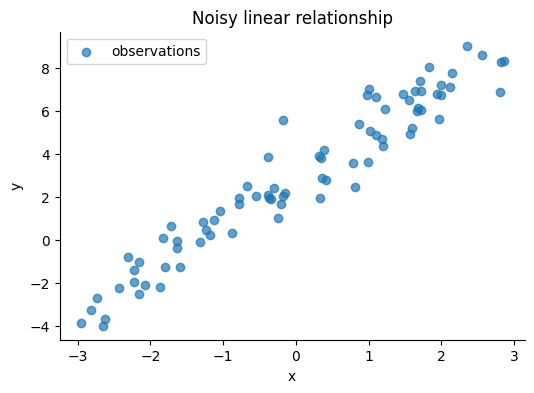

In [2]:
# Generate toy data

# Set number of points to generate 
n = 80

# Generate x axis data in the range of -3 to +3 
# This is generated using a uniform distribution from numpy 
x = rng.uniform(-3, 3, size = n)

# Generate noise in the same shape from a Gaussian (normal) distribution
noise = rng.normal(0, 1.0, size=n)

# Define the "true" distribution
y = 3 + 2 * x + noise

# Some code to plot everything 
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.7, label="observations")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("Noisy linear relationship")
plt.show()

## Scalar (Non-Matrix) View
We can estimate the slope $\theta_1$ and intercept $\theta_0$ with the familiar formulas:
$\theta_1 = \dfrac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}$ and $\theta_0 = \bar{y} - \theta_1\bar{x}$.
This is equivalent to minimizing the mean squared error $\dfrac{1}{m}\sum (y_i - (\theta_0 + \theta_1 x_i))^2$.
We'll compute these directly to see the mechanics.

In [3]:
# Compute slope and intercept from formulas
x_mean = np.mean(x)
y_mean = np.mean(y)
numerator = np.sum((x - x_mean) * (y - y_mean))
denominator = np.sum((x - x_mean) ** 2)
theta_1 = numerator / denominator
theta_0 = y_mean - theta_1 * x_mean

print(f"Manual slope (b1): {theta_1:.3f}")
print(f"Manual intercept (b0): {theta_0:.3f}")

Manual slope (b1): 2.078
Manual intercept (b0): 2.874


## Predictions and Error (Scalar View)
Using $\hat{y} = \theta_0 + \theta_1 x$ we can evaluate fit quality via mean squared error (MSE).

In [4]:
# Define loss function
def mean_squared_error(y_true, y_pred):
    
    return np.mean((y_true - y_pred) ** 2)

Manual MSE: 0.854


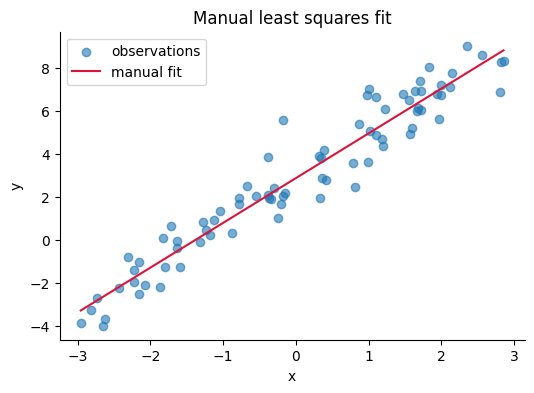

In [5]:
# Predict and evaluate
# Define the learned model in terms of theta_0 and theta_1
y_hat = theta_0 + theta_1 * x

# Compute and print loss 
mse_manual = mean_squared_error(y, y_hat)
print(f"Manual MSE: {mse_manual:.3f}")

# Plot results
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.6, label="observations")
ax.plot(np.sort(x), y_hat[np.argsort(x)], color="crimson", label="manual fit")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Manual least squares fit")
ax.legend()
plt.show()

## Matrix (Normal Equation) View
Stack inputs into a design matrix $X$ with a bias column of ones. The closed-form solution is
$$\theta = (X^\top X)^{-1} X^\top y,$$
where $\theta = [\theta_0, \theta_1]^\top$. This is the same solution we derived in scalars, just written compactly.

In [6]:
# Solve with the normal equation

# Here we add a column of ones to X to account for the intercept term (bias term)
X = np.column_stack([np.ones_like(x), x])

# We use np.linalg.inv to compute the inverse of a matrix
theta = np.linalg.inv(X.T @ X) @ X.T @ y

theta_0_matrix, theta_1_matrix = theta

print(f"Matrix slope (theta_1): {theta_1_matrix:.3f}")
print(f"Matrix intercept (theta_0): {theta_0_matrix:.3f}")

Matrix slope (theta_1): 2.078
Matrix intercept (theta_0): 2.874


## Quick Check with scikit-learn
`LinearRegression` should match the analytic solutions above.

In [7]:
# Fit with scikit-learn
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
print(f"sklearn slope (coef): {model.coef_[0]:.3f}")
print(f"sklearn intercept: {model.intercept_:.3f}")

sklearn slope (coef): 2.078
sklearn intercept: 2.874


## Gradient Descent Implementation

In [8]:
# Learning rate
alpha = 0.001

# Number of iterations
n_iterations = 1000

# Initialize parameters
theta_0_gd = 0.0
theta_1_gd = 0.0

Recall that gradient of $\theta_0$ is $\frac{\partial L(\theta)}{\partial \theta_0} = \frac{2}{m}\sum_{i = 1}^m (\theta_0 + \theta_1 x_i - y_i)$

and 

gradient of $\theta_1$ is $\frac{\partial L(\theta)}{\partial \theta_1} = \frac{2}{m}\sum_{i = 1}^m x_i \cdot (\theta_0 + \theta_1 x_i - y_i)$

GD slope (theta_1): 2.076
GD intercept (theta_0): 2.492
GD MSE: 1.000


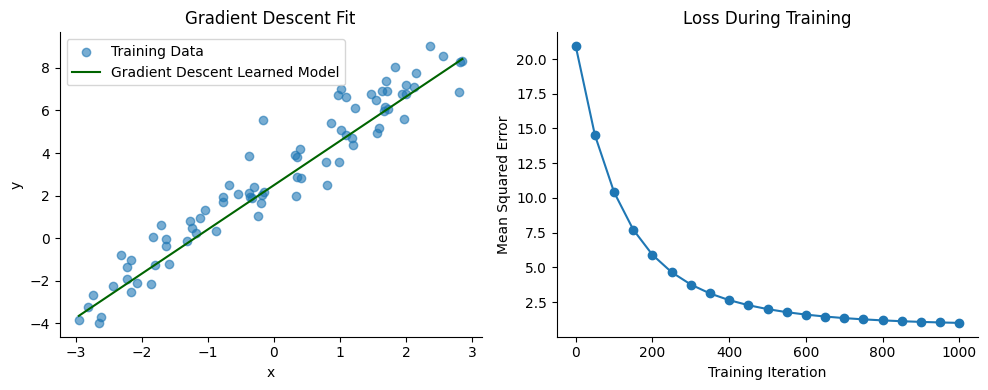

In [9]:
# Run gradient descent for simple linear regression
m = len(x)
loss_history = []

for _ in range(n_iterations):

    # Define the model equation 
    y_pred = theta_0_gd + theta_1_gd * x

    # Error term for gradient calculation
    # This is not the loss term 
    error = y_pred - y

    # Gradients for intercept and slope (vectorized)
    grad_b0 = (2 / m) * np.sum(error)
    grad_b1 = (2 / m) * np.sum(error * x)
    
    # Update parameters
    theta_0_gd -= alpha * grad_b0
    theta_1_gd -= alpha * grad_b1

    if _ % 50 == 0 or _ == n_iterations - 1:
        loss_history.append(mean_squared_error(y, y_pred))

print(f"GD slope (theta_1): {theta_1_gd:.3f}")
print(f"GD intercept (theta_0): {theta_0_gd:.3f}")
print(f"GD MSE: {mean_squared_error(y, theta_0_gd + theta_1_gd * x):.3f}")

# Plot fit and loss curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(x, y, alpha=0.6, label="Training Data")
ax1.plot(np.sort(x), (theta_0_gd + theta_1_gd * np.sort(x)), color="darkgreen", label="Gradient Descent Learned Model")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Gradient Descent Fit")
ax1.legend()

ax2.plot(np.arange(len(loss_history)) * 50, loss_history, marker="o")
ax2.set_xlabel("Training Iteration")
ax2.set_ylabel("Mean Squared Error")
ax2.set_title("Loss During Training")
plt.tight_layout()
plt.show()

## Gradient Descent using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # One input feature, one output

    def forward(self, x):
        return self.linear(x)
    
# Instantiate the model, define loss function and optimizer
model = LinearRegressionModel()
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Convert data to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1) 

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_tensor)
    
    # Compute loss
    loss = loss_function(y_pred, y_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}') 

Epoch [100/1000], Loss: 1.0458
Epoch [200/1000], Loss: 0.8575
Epoch [300/1000], Loss: 0.8542
Epoch [400/1000], Loss: 0.8541
Epoch [500/1000], Loss: 0.8541
Epoch [600/1000], Loss: 0.8541
Epoch [700/1000], Loss: 0.8541
Epoch [800/1000], Loss: 0.8541
Epoch [900/1000], Loss: 0.8541
Epoch [1000/1000], Loss: 0.8541


In [23]:
print(f"PyTorch slope (weight): {model.linear.weight.item():.3f}")
print(f"PyTorch intercept (bias): {model.linear.bias.item():.3f}")

PyTorch slope (weight): 2.078
PyTorch intercept (bias): 2.874
